# Interior Design Style Model

This is the final notebook for the interior design style model, where we collect the data from two API's and merge it into one dataframe. 
Once we merge the dataset, we preprocess it and test it on different ML and DL models to evaluate their performance.

**Please note:** 
- The dataset is quite small and results may not be the best, because data quality and accuracy of the stye representations from the API's. 
- The ML and DL models do not involve super endless hypertunning to get the highest possible results, because the main objective is to get a model that gets at least 50% accuracy and to test my capabilites for the first personal project

# Data Collection from the API's

In [23]:
# Importing the required libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from pexels_api import API

# Libraries for NLP
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


# For improving the NLP
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# For Linear SVM
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import time


# For Deep Learning Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score

In [41]:
# API information

url = 'YOUR-API-KEY'
Api_key = 'YOUR-API-KEY'
api = API(Api_key)


In [7]:
# API Functions

def all_df(style_list):
    """Fuction gets API data from a list of styles 
    and creates one full df with the required columns"""
    style_df = []
    
    for index, style in enumerate(style_list):
        data_list = []
        for i in range(1,20):
                photos = requests.get(url+f'&q={style_list[index]}&image_type=photo&page={i}').json()
                data_list.append(pd.DataFrame.from_dict(photos['hits']))
                
        merged = pd.concat(data_list)
        merged = merged[['id', 'tags']]
        merged['style'] = style
        style_df.append(merged)
    
    all_df = pd.concat(style_df)
    
    return all_df


def all_df_pexels(style_list):
    """Fuction gets API data from a list of styles 
    and creates one full df with the required columns"""
    style_df = []
    
    for index, style in enumerate(style_list):
        data_list = []
        for i in range(1,10):
                photos = api.search(style, page=i, results_per_page=45)['photos']
                data_list.append(pd.DataFrame.from_dict(photos))
                
        merged = pd.concat(data_list)
        merged = merged[['id', 'alt']]
        merged['style'] = style
        style_df.append(merged)
    
    all_df = pd.concat(style_df)
    
    return all_df


In [8]:
pixabay_df = all_df(['modern+interior','industrial+interior','minimalist+interior','contemporary+interior', 'rustic+interior']).copy()
pexels_df = all_df_pexels(['modern interior','industrial interior','minimalist interior','contemporary interior', 'rustic interior', 'scandinavian interior']).copy()

# Dataset preprocessing before merging

C:\Users\Richard\AppData\Local\Temp/ipykernel_20428/1711117945.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pixabay_df['style'] = pixabay_df['style'].str.replace('+', ' ')


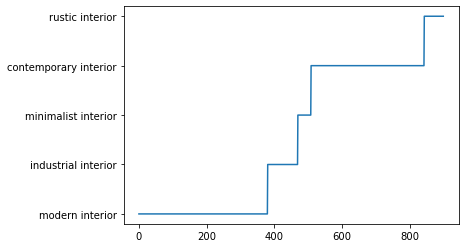

In [9]:
pixabay_df['style'] = pixabay_df['style'].str.replace('+', ' ')
pixabay_df.reset_index(inplace=True)
pixabay_df.drop(columns='index',inplace=True)
plt.plot(pixabay_df['style'])

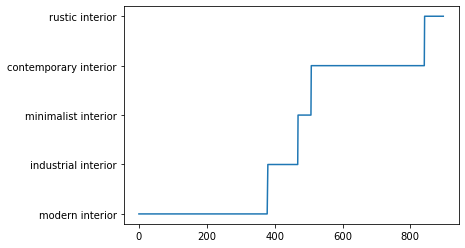

In [10]:
pixabay_df.drop_duplicates(subset=['tags'], inplace=True)
plt.plot(pixabay_df['style'])

In [11]:
pixabay_df.reset_index(inplace=True)
pixabay_df.drop(columns='index',inplace=True)

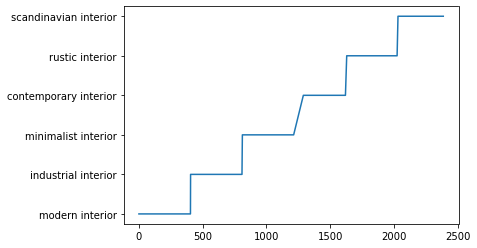

In [12]:
pexels_df.reset_index(inplace=True)
pexels_df.drop(columns='index',inplace=True)
pexels_df.drop_duplicates(subset=['alt'], inplace=True)
pexels_df['tags']=pexels_df['alt']
pexels_df.drop(columns='alt',inplace=True)
plt.plot(pexels_df['style'])

## Merging the datasets

In [13]:
style_data = pd.concat([pexels_df, pixabay_df])
style_data['style'].unique()

# Saving the dataset
compression_opts = dict(method='zip',archive_name='style.csv')  

style_data.to_csv('style.zip', index=False, compression=compression_opts)

# Preprocessing for the ML modeling

In [14]:
# Function to clean the text information

def clean(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

In [15]:
# Apply to all texts
style_data['tags_clean'] = style_data.tags.apply(clean)
style_data['tags_clean'] = style_data['tags_clean'].astype('str')
style_data

,id,style,tags,tags_clean
0,10339232,modern interior,Modern Office Interior,"['modern', 'office', 'interior']"
1,7546288,modern interior,White and Brown Bed Linen,"['white', 'brown', 'bed', 'linen']"
2,7546218,modern interior,A Dining Table and Chairs with Hanging Lights ...,"['dining', 'table', 'chair', 'hanging', 'light..."
3,7545855,modern interior,A White Kitchen Cabinets With Sink,"['white', 'kitchen', 'cabinet', 'sink']"
4,7546276,modern interior,"Free stock photo of apartment, bed, bedroom","['free', 'stock', 'photo', 'apartment', 'bed',..."
...,...,...,...,...
597,3509742,rustic interior,"coffee brazil, coffee, roça","['coffee', 'brazil', 'coffee', 'roça']"
598,3886504,rustic interior,"silk flowers, floral arrangement, vase","['silk', 'flower', 'floral', 'arrangement', 'v..."
599,3886500,rustic interior,"skeleton key, antique, old world","['skeleton', 'key', 'antique', 'old', 'world']"
600,2368997,rustic interior,"rope, lamp, chandelier","['rope', 'lamp', 'chandelier']"


# Naive Bayes Model

In [44]:
# Train Test Split

X = style_data['tags_clean']
y = style_data['style']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [19]:
# Create Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

# Set parameters to search
parameters = {
    'tfidf__ngram_range': ((1,1), (2,2), (3,3)),
    'nb__alpha': (0.01,0.1,1),}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, 
                           verbose=1, scoring = "accuracy", 
                           refit=True, cv=5)

grid_search.fit(X_train,y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': (0.01, 0.1, 1),
                         'tfidf__ngram_range': ((1, 1), (2, 2), (3, 3))},
             scoring='accuracy', verbose=1)

In [20]:
display(grid_search.best_params_)
grid_search.best_score_

{'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}

0.5061016949152543

In [21]:
# Build the model
model = make_pipeline(TfidfVectorizer(ngram_range=(1,1)), MultinomialNB(alpha=0.1))

# Train the model using the training data
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=0.1))])

In [22]:
# Predict the categories of the test data
predicted_categories = model.predict(X_test)

In [24]:
print("The accuracy is {}".format(accuracy_score(y_test, predicted_categories)))

The accuracy is 0.5126582278481012


# Linear SVM Model

In [25]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

Wall time: 0 ns
accuracy 0.5253164556962026


# Deep Learning Models

In [26]:
# Obtaining the y values one more time in numerical representation
y = pd.get_dummies(style_data['style']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (2106, 6)


In [27]:
# Train Test Split
X = style_data['tags']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [28]:
# Tokenazation and padding

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)


X_train_pad = pad_sequences(X_train_token, maxlen=200, dtype='float32')
X_test_pad = pad_sequences(X_test_token, maxlen=200, dtype='float32')

In [29]:
# Vocabulary size
vocab_size = len(tokenizer.word_index)
vocab_size

1356

## CNN Model

In [30]:
def cnn_model(vocab_size):
    model = Sequential()
    model.add(layers.Embedding(input_dim = vocab_size+1, output_dim=10, mask_zero=False, input_length=200))
    model.add(layers.Conv1D(16,3))
    model.add(layers.Flatten())
    model.add(layers.Dense(5,))
    model.add(layers.Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

cnn_model = cnn_model(vocab_size)

In [31]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 10)           13570     
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 16)           496       
_________________________________________________________________
flatten (Flatten)            (None, 3168)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 15845     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 36        
Total params: 29,947
Trainable params: 29,947
Non-trainable params: 0
_________________________________________________________________


In [32]:
es = EarlyStopping(patience=10, restore_best_weights=True)

cnn_model.fit(X_train_pad, y_train, 
          epochs=100, 
          batch_size=16,
          validation_split=0.2,
          callbacks=[es]
         )

Epoch 1/100
74/74 [==============================] - 1s 7ms/step - loss: 1.6900 - accuracy: 0.3249 - val_loss: 1.6836 - val_accuracy: 0.3525
Epoch 2/100
74/74 [==============================] - 0s 4ms/step - loss: 1.5754 - accuracy: 0.3885 - val_loss: 1.5195 - val_accuracy: 0.4034
Epoch 3/100
74/74 [==============================] - 0s 5ms/step - loss: 1.4020 - accuracy: 0.4648 - val_loss: 1.4528 - val_accuracy: 0.4305
Epoch 4/100
74/74 [==============================] - 0s 6ms/step - loss: 1.2867 - accuracy: 0.4970 - val_loss: 1.4542 - val_accuracy: 0.4271
Epoch 5/100
74/74 [==============================] - 0s 6ms/step - loss: 1.2044 - accuracy: 0.5276 - val_loss: 1.4542 - val_accuracy: 0.4237
Epoch 6/100
74/74 [==============================] - 0s 6ms/step - loss: 1.1215 - accuracy: 0.5632 - val_loss: 1.5260 - val_accuracy: 0.4068
Epoch 7/100
74/74 [==============================] - 0s 5ms/step - loss: 1.0451 - accuracy: 0.5954 - val_loss: 1.5148 - val_accuracy: 0.4339
Epoch 8/100
7

In [33]:
res = cnn_model.evaluate(X_test_pad, y_test)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

20/20 [==============================] - 0s 5ms/step - loss: 1.4419 - accuracy: 0.4288
The accuracy evaluated on the test set is of 42.880%


## RNN Model

In [34]:
def rnn_model(vocab_size):
    model = Sequential()
    model.add(layers.Embedding(input_dim = vocab_size+1, output_dim=10, mask_zero=False, input_length=200))
    model.add(layers.LSTM(16))
    model.add(layers.Flatten())
    model.add(layers.Dense(5,))
    model.add(layers.Dense(6, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

rnn_model = rnn_model(vocab_size)

In [35]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 10)           13570     
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1728      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 36        
Total params: 15,419
Trainable params: 15,419
Non-trainable params: 0
_________________________________________________________________


In [36]:
es = EarlyStopping(patience=10, restore_best_weights=True)

rnn_model.fit(X_train_pad, y_train, 
          epochs=100, 
          batch_size=16,
          validation_split=0.2,
          callbacks=[es]
         )

Epoch 1/100
74/74 [==============================] - 8s 108ms/step - loss: 1.7187 - accuracy: 0.3265 - val_loss: 1.7073 - val_accuracy: 0.3085
Epoch 2/100
74/74 [==============================] - 7s 90ms/step - loss: 1.6455 - accuracy: 0.3333 - val_loss: 1.6361 - val_accuracy: 0.3661
Epoch 3/100
74/74 [==============================] - 6s 77ms/step - loss: 1.5399 - accuracy: 0.4258 - val_loss: 1.5407 - val_accuracy: 0.4203
Epoch 4/100
74/74 [==============================] - 8s 108ms/step - loss: 1.4139 - accuracy: 0.4538 - val_loss: 1.4734 - val_accuracy: 0.4203
Epoch 5/100
74/74 [==============================] - 7s 88ms/step - loss: 1.3240 - accuracy: 0.4682 - val_loss: 1.4424 - val_accuracy: 0.4136
Epoch 6/100
74/74 [==============================] - 6s 79ms/step - loss: 1.2522 - accuracy: 0.4902 - val_loss: 1.4267 - val_accuracy: 0.4169
Epoch 7/100
74/74 [==============================] - 6s 81ms/step - loss: 1.1914 - accuracy: 0.5174 - val_loss: 1.4495 - val_accuracy: 0.4305
Epoc

In [37]:
res_rnn = rnn_model.evaluate(X_test_pad, y_test)
print(f'The accuracy evaluated on the test set is of {res_rnn[1]*100:.3f}%')

20/20 [==============================] - 0s 13ms/step - loss: 1.4333 - accuracy: 0.4699
The accuracy evaluated on the test set is of 46.994%


In [40]:
# custom function to have fun
def my_predictions_deep(my_sentence, model):
    my_sentence = tokenizer.texts_to_sequences(my_sentence)
    my_sentence = pad_sequences(my_sentence, maxlen=200, dtype='float32')
    prediction = np.argmax(model.predict(my_sentence), axis=-1)
    return prediction[0]

my_sentence = 'I like modern homes'
print(my_predictions_deep(my_sentence, rnn_model))

3


# Selecting the Model and making it into pickle file

In [42]:
import pickle

pickle.dump(sgd, open('model_sgd.pkl','wb'))

In [45]:
loaded_model = pickle.load(open('model_sgd.pkl', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.5253164556962026
